## 1. Importing Libraries

In [1]:
#wandb for logging experiments
#torchmetrics for GAN evaluation using FID and IS Score
!pip install wandb torchmetrics[image]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#allow duplicate libraries
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [4]:
#Checking GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
#Check CPU and GPU
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7970689683186162959
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14415560704
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3141714721514472133
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [6]:
# WandB – Install the W&B library
%pip install wandb -q

In [7]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils import data
import torchvision
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.autograd import Variable
from typing import Tuple, Optional, Union, Dict, Sequence
from functools import partial
from torchvision.utils import save_image
from tqdm import tqdm
import torch.nn.functional as F
from torch.autograd import Variable

# WandB – Import the wandb library
import wandb
wandb.login()
wandb.init(project="DEEL-CA2-GAN") # Change the project name based on your W & B account

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: raymondng009. Use `wandb login --relogin` to force relogin


Random Seed:  999


API Login Key for Wandb
7807b65cfd69b4131fd5347c75e9e6fd783eb5d8

In [8]:
#Environment setup
from torch import cuda, optim
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

#Set computation device
device = torch.device("cuda:0" if train_on_gpu else "cpu")

multi_gpu = False
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
1 gpus detected.


## 2. Data Preprocessing

In [9]:
#Calculate mean and std here with train_data 
train_data = dataset.CIFAR10('./data', train=True, download=True)

# Stick all the images together 
x = np.concatenate([np.asarray(train_data[i][0]) for i in range(len(train_data))])

# calculate the mean and std along the (0, 1) axes
data_mean = np.mean(x, axis=(0, 1))/255
data_std = np.std(x, axis=(0, 1))/255
# the the mean and std
data_mean=data_mean.tolist()
data_std=data_std.tolist()

Files already downloaded and verified


In [10]:
print(data_mean)
print(data_std)

[0.49139967861519607, 0.48215840839460783, 0.44653091444546567]
[0.24703223246174102, 0.24348512800151828, 0.26158784172803257]


In [11]:
#Set mean and std values of CIFAR-10 

#Calculated values from above
data_mean = (0.491, 0.482, 0.446)
data_std = (0.247, 0.243, 0.261)

#Normalizing with 0.5 values
normalize_mean_std = (0.5, 0.5, 0.5)

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(normalize_mean_std, normalize_mean_std)
])

#Download both train and test data with preprocessing of normalize and to tensor
#From torchvision.data
train_data = dataset.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
test_data = dataset.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

dataConcat = data.ConcatDataset((train_data, test_data))

Files already downloaded and verified
Files already downloaded and verified


In [12]:
import torchvision.transforms.functional as F
def inverseNormalize(imgs: torch.Tensor, mean=data_mean, std=data_std):
    mean = torch.as_tensor(mean)
    std = torch.as_tensor(std)
    std_inv = 1 / (std + 1e-7)
    mean_inv = -mean * std_inv

    return F.normalize(imgs, mean=mean_inv, std=std_inv)

In [13]:
#Concatenated the trg and test datasets
concat_data:data.Dataset = dataConcat
data_loader = data.DataLoader(
    concat_data,
    batch_size=128,
    shuffle=True
)
cifar10_classnames=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [14]:
#Basic EDA with labels for train_data
demo_loader = torch.utils.data.DataLoader(train_data, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 3, 32, 32]) torch.Size([10])


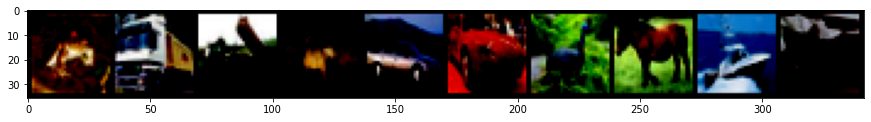

In [15]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))

## 3. Helper Functions

In [16]:
def save_generator_image(image, path):
    """
    Function to save torch image batches
    :param image: image tensor batch
    :param path: path name to save image
    """
    save_image(image, path, normalize=True)

In [17]:
#Returns list of classname based on label tensor
def return_classname(labels: torch.Tensor, classname_mapping: Sequence[str])->Sequence[str]:
    return list(map(lambda l: classname_mapping[l], labels))

In [18]:
#Generate plot of image batch
def plot(epoch, imgs, labels, inv_preprocessing, grid_row=10, figsize=(10,10), save_path=None, print=None):

    #Inverse processing
    if inv_preprocessing is not None:
        for inv in inv_preprocessing:
            imgs = inv(imgs)

    #Plot figure
    fig = plt.figure(figsize=figsize, tight_layout=True)
    for i in range(grid_row * grid_row):
        ax = fig.add_subplot(grid_row, grid_row, i + 1)
        ax.imshow(F.to_pil_image(imgs[i]))
        ax.set_title("{}".format(labels[i] if labels else ""))
        ax.axis("off")

    #Save figure 
    if save_path:
        plt.savefig(f"{save_path}/generated_img_{epoch}.png")
    #log in wandb
    wandb.log({"generated_images":wandb.Image(imgs), "epoch":epoch})
    
    if print:
      #Plot the graph out
      plt.show()

In [19]:
#Save generator image batches
#Generator will generate fake images in batches and this function will save those images in batches
def save_gen_imgs(epoch, base_folder, generator, image_num, n_classes, latent_dim, classname_mapping, device, inv_preprocessing, data_loader=data_loader):
    #Calculate batch size
    batch_size = image_num//n_classes
    n_batch = image_num//batch_size
    for i, (imgs, _) in enumerate(data_loader):
       latent_space = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))
    #Generate grids
    gen_grids = torch.arange(0, n_classes, device=device)\
                    .tile(100)\
                    .reshape(batch_size, n_batch)\
                    .T

    # Randomly shuffle the labels or else the generated result will be bad 
    # due different distribution than training
    # Generate Random Indices
    perm_indices = torch.randperm(batch_size*n_batch)
    # Generate Indices Mapping
    random_map = {idx: int(random_idx) for idx, random_idx in enumerate(perm_indices)}
    reverse_map = {v:k for k,v in random_map.items()}
    # Generate Indices List for Mapping
    to_random = list(random_map.values())
    to_ordered = list({reverse_key: reverse_map[reverse_key] for reverse_key in sorted(reverse_map)}.values())
    # Randomized Label
    #gen_labels = gen_grids.reshape(-1)[to_random].reshape(n_batch, batch_size)

    gen_imgs = []
    with torch.no_grad():
        gen_img = generator(latent_space)
        gen_imgs.append(gen_img.cpu())
            
    gen_imgs_torch = torch.stack(gen_imgs).reshape(-1, 3, 32, 32).cpu()
    #gen_labels = np.array(return_classname(gen_labels.reshape(-1).cpu(), classname_mapping))
    # Revert Randomized Label and Image to Ordered Form
    gen_imgs_torch_sorted = gen_imgs_torch[to_ordered]
   # gen_labels_sorted = gen_labels[to_ordered]

    for folder_dir in [base_folder, f"{base_folder}/{epoch}", 
                        *[f"{base_folder}/{epoch}/{classname}" for classname in classname_mapping]]:
        if not os.path.exists(folder_dir):
            os.makedirs(folder_dir)

    if inv_preprocessing is not None:
        gen_imgs_torch_sorted = inv_preprocessing(gen_imgs_torch_sorted)

    for idx, (img) in enumerate(zip(gen_imgs_torch_sorted)):
        F.to_pil_image(img).save(f"{base_folder}/{epoch}/{idx}.png")

In [20]:
#Function to create noise tensor
#Generator needs a random noise tensor to create fake images
def create_noise(sample_size, nz):#sample size should be fixed to 64 defined later, nz is dimension of noise vector which si 100 dimensional
    """
    Fucntion to create noise
    :param sample_size: fixed sample size or batch size
    :param nz: latent vector size
    :returns random noise vector
    """
    return torch.randn(sample_size, nz, 1, 1).to(device)

#Print size of noisne vector [64, 100, 1, 1]

In [21]:
#Creating fake and real labels
def label_real(size):
    """
    Fucntion to create real labels (ones)
    :param size: batch size
    :return real label vector
    """
    data = torch.ones(size, 1)
    return data.to(device)
def label_fake(size):
    """
    Fucntion to create fake labels (zeros)
    :param size: batch size
    :returns fake label vector
    """
    data = torch.zeros(size, 1)
    return data.to(device)

#Example if its real => 1
#if its fake => 0
#Since batch size is 64 output for real images will be [1,1,1,1,...] 64 times

In [22]:
##Weight Initisalization
#we need to initialize the weights of the generator and discriminator from a zero-centered Normal Distribution. 
def weights_init(m):
    """
    This function initializes the model weights randomly from a 
    Normal distribution. This follows the specification from the DCGAN paper.
    https://arxiv.org/pdf/1511.06434.pdf
    Source: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## 4. Visualizations

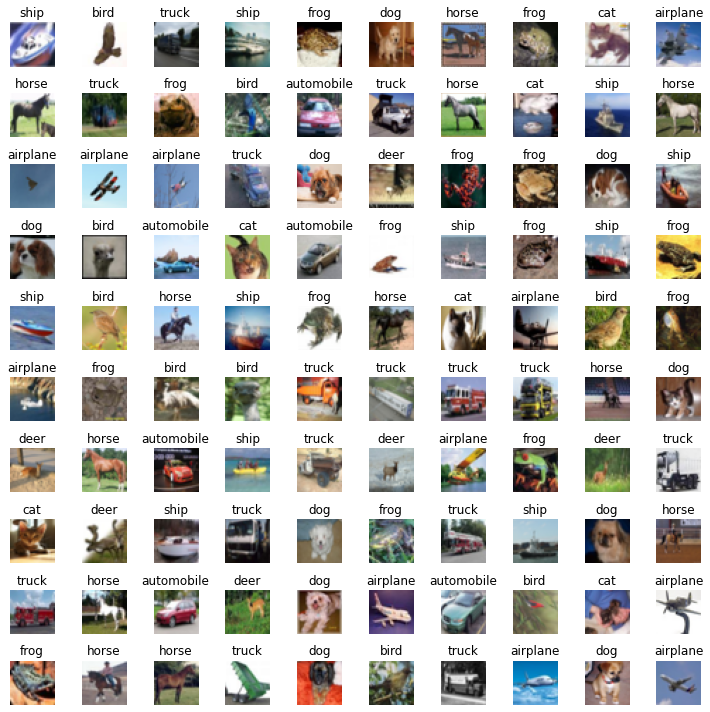

In [23]:
#Between -1 and 1 for normalization similar to generator output 'tanh' range -1 to 1
img_batch, labels_batch = next(iter(data_loader))
assert torch.max(img_batch).cpu().item() == 1.0
assert torch.min(img_batch).cpu().item() == -1.0

#Plot with epoch of 0 since this is a test
plot(epoch=0,imgs=img_batch,labels=return_classname(labels_batch, cifar10_classnames),inv_preprocessing=[partial(inverseNormalize, mean=normalize_mean_std, std=normalize_mean_std)], print=True)

## 5. Hyperparameters & Modeling Functions

In [24]:
hparams = dict(
      #Number of classes 
      n_classes = 10, #CIFAR-10 has 10 classes
      # Spatial size of training images. All images will be resized to this
      #   size using a transformer.
      image_size = 32,
      #Number of output channels RGB
      channels=3,

      #Model Parameters
      latent_dim = 100, #Size of z latent vector (i.e. size of generator input)

      #Training Parameters
      # Batch size during training
      batch_size = 128,
      train_d_times = 1,
      train_g_times = 1
)

In [25]:
#Hinge Loss from https://github.com/POSTECH-CVLab/PyTorch-StudioGAN/blob/8c9aa5a2e9bb33eca711327c085db5ce50ff7fc0/src/utils/losses.py

import torch.nn.functional 

def d_hinge(d_logit_real, d_logit_fake):
    return torch.mean(torch.nn.functional.relu(1. - d_logit_real)) + torch.mean(torch.nn.functional.relu(1. + d_logit_fake))

def g_hinge(d_logit_fake):
    return -torch.mean(d_logit_fake)

### Training Function

In [26]:
def train_batch(epoch, data_loader, generator, discriminator, d_hinge, g_hinge, adversarial_loss, g_optimizer, d_optimizer, device, inv_preprocessing, latent_dim=100, sample_interval=200,**kwargs):

    generator.train()
    discriminator.train()
    disc_loss_array = []
    gen_loss_array = []
    gen_imgs_array = []
    for i, (imgs, _) in enumerate(data_loader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        g_optimizer.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)
        generated_img = gen_imgs.cpu().detach()

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        gen_loss_array.append(g_loss.item())

        g_loss.backward()
        g_optimizer.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        d_optimizer.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        disc_loss_array.append(d_loss.item())

        d_loss.backward()
        d_optimizer.step()


    # Wandb Logging of mean for entire epoch
    wandb.log(dict(DiscLoss=np.mean(disc_loss_array), GenLoss=np.mean(gen_loss_array)))

    print(f"Epoch {epoch}] Discriminator Loss: {np.mean(disc_loss_array):.4f}, Generator Loss: {np.mean(gen_loss_array):.4f}")

    save_image(generated_img, fp="outputs/gen_img{epoch}.png", normalize=True)

### Evaluation Functions

In [27]:
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
from torch import nn
from torch.utils import data
from PIL import Image

class FID_Score(FrechetInceptionDistance):
    def __init__(self, device=None, **kwargs) -> None:
        super().__init__(**kwargs)
        if not device:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
    
    #Resize images to 299, 299
    def resize_images(self, batch):
        arr = []
        for img in batch:
            pil_img = transforms.ToPILImage()(img)
            resized_img = pil_img.resize((299, 299), Image.BILINEAR)
            img_tensor = transforms.ToTensor()(resized_img)
            arr.append(img_tensor)
        return torch.stack(arr)

    def evaluate(self, generator, real_data, latent_dim, n_classes, batch_size=128, sample_size=10000, inv_preprocessing=None):

        n_batch = (sample_size + batch_size - 1) // batch_size
        data_loader = data.DataLoader(real_data, batch_size=batch_size)
        data_iter = iter(data_loader)

        with torch.no_grad():
            for index in range(n_batch):
                latent_space = torch.normal(
                    0, 1, (batch_size, latent_dim), device=self._device, requires_grad=False)
                gen_labels = torch.randint(
                    0, n_classes, (batch_size,), device=self._device, requires_grad=False)
                
                real_img, _ = next(data_iter)
                fake_img = generator(latent_space)

                if inv_preprocessing:
                    real_img = inv_preprocessing(real_img)
                    fake_img = inv_preprocessing(fake_img)
                
                uint_real_img = (self.resize_images(real_img)*255).type(torch.uint8)
                uint_fake_img = (self.resize_images(fake_img)*255).type(torch.uint8)

                uint_real_img = uint_real_img.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
                uint_fake_img = uint_fake_img.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

                self.update(uint_real_img, real=True)
                self.update(uint_fake_img, real=False)

        return self.compute().cpu().item()

class IS_Score(InceptionScore):
    def __init__(self, device=None, **kwargs) -> None:
        super().__init__(**kwargs)
        if not device:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)

    #Resize images to 299, 299
    def resize_images(self, batch):
        arr = []
        for img in batch:
            pil_img = transforms.ToPILImage()(img)
            resized_img = pil_img.resize((299, 299), Image.BILINEAR)
            img_tensor = transforms.ToTensor()(resized_img)
            arr.append(img_tensor)
        return torch.stack(arr)

    def evaluate(self, generator, latent_dim, n_classes, batch_size=128, sample_size=10000, inv_preprocessing=None):

        n_batch = (sample_size + batch_size - 1) // batch_size

        with torch.no_grad():
            for index in range(n_batch):
                latent_space = torch.normal(
                    0, 1, (batch_size, latent_dim), device=self._device, requires_grad=False)
                gen_labels = torch.randint(
                    0, n_classes, (batch_size,), device=self._device, requires_grad=False)
                
                fake_img = generator(latent_space)
                
                if inv_preprocessing:
                    fake_img = inv_preprocessing(fake_img)

                uint_fake_img = (self.resize_images(fake_img)*255).type(torch.uint8)

                uint_fake_img = uint_fake_img.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

                self.update(uint_fake_img)

        return self.compute()[0].cpu().item()

In [28]:
def evaluate(epoch, generator, real_data, batch_size, latent_dim, n_classes, **kwargs):  
    with torch.no_grad():
        latent_space = torch.normal(
            0, 1, (batch_size, latent_dim), device=device, requires_grad=False)
        gen_labels = torch.randint(
            0, n_classes, (batch_size,), device=device, requires_grad=False)
        imgs = generator(latent_space)

    # Evaluate FID10k
    fidscore = FID_Score()
    fid_score = fidscore.evaluate(generator, real_data, latent_dim, n_classes, inv_preprocessing = partial(inverseNormalize, mean=normalize_mean_std, std=normalize_mean_std))
    print(f"FID_Score: {fid_score}")
    wandb.log({"FID_score": fid_score})

    # Evaluate IS10k
    isscore = IS_Score()
    is_score = isscore.evaluate(generator, latent_dim, n_classes, inv_preprocessing = partial(inverseNormalize, mean=normalize_mean_std, std=normalize_mean_std))
    print(f"Inception_Score: {is_score}")
    wandb.log({"IS_score": is_score})

    # Plot Image
    if not os.path.exists('images'):
        os.makedirs('images')

    plot(epoch,imgs.cpu(),labels=return_classname(gen_labels.cpu(), cifar10_classnames),save_path="images",inv_preprocessing=[partial(inverseNormalize, mean=normalize_mean_std, std=normalize_mean_std)], print=None)

## 6. Modeling 


## DCCGAN Model technical paper is from https://arxiv.org/pdf/1807.09499.pdf
The models architecture is inspired from "https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/dcgan/dcgan.py"

Architecture consists of some conv and batch norm layers from CNN

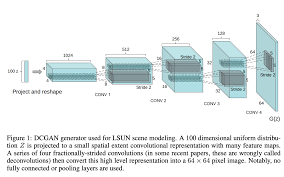

In [29]:
class Generator(nn.Module):
    def __init__(self, latent_dim, image_size, channels, **kwargs):
        super(Generator, self).__init__()

        self.init_size = image_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [30]:
class Discriminator(nn.Module):
    def __init__(self, image_size, channels, **kwargs):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = image_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

In [31]:
#Initialize Model
epoch = 0

#Initialize generator weights
generator = Generator(**hparams).apply(weights_init).to(device)
#Initialize discriminator weights
discriminator = Discriminator(**hparams).apply(weights_init).to(device)

#Set Training Hyperparameters
# Loss function
adversarial_loss = torch.nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(),lr=0.0002, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(),lr=0.0002, betas=(0.5, 0.999))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [32]:
print('GENERATOR Architecture:')
print(generator)
print('*************************')
print('\nDISCRIMINATOR Architecture:')
print(discriminator)

GENERATOR Architecture:
Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)
*************************

DISCRIMINATOR Architecture:
Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=

In [ ]:
#Training cell for number of epochs
for i in range(200):
  #Train one batch of mages
    train_batch(epoch, data_loader,generator,discriminator,d_hinge,g_hinge,adversarial_loss,g_optimizer,d_optimizer,device, inv_preprocessing=partial(inverseNormalize, mean=normalize_mean_std, std=normalize_mean_std),**hparams)

    if epoch % 5 == 0:
        #Evaluate FID Score and IS Score every 5 epochs
        evaluate(epoch, generator, concat_data, **hparams)

    epoch += 1

Epoch 0] Discriminator Loss: 0.6913, Generator Loss: 0.6971
FID_Score: 301.42864990234375


/usr/local/lib/python3.8/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


Inception_Score: 1.3708906173706055
Epoch 1] Discriminator Loss: 0.6932, Generator Loss: 0.6942
Epoch 2] Discriminator Loss: 0.6927, Generator Loss: 0.6952
Epoch 3] Discriminator Loss: 0.6919, Generator Loss: 0.6972
Epoch 4] Discriminator Loss: 0.6930, Generator Loss: 0.6939
Epoch 5] Discriminator Loss: 0.6933, Generator Loss: 0.6932
FID_Score: 222.8592071533203
Inception_Score: 1.784019112586975
Epoch 6] Discriminator Loss: 0.6931, Generator Loss: 0.6931
Epoch 7] Discriminator Loss: 0.6931, Generator Loss: 0.6934
Epoch 8] Discriminator Loss: 0.6931, Generator Loss: 0.6933
Epoch 9] Discriminator Loss: 0.6932, Generator Loss: 0.6933
Epoch 10] Discriminator Loss: 0.6932, Generator Loss: 0.6932
FID_Score: 229.96560668945312
Inception_Score: 1.9100065231323242
Epoch 11] Discriminator Loss: 0.6930, Generator Loss: 0.6935
Epoch 12] Discriminator Loss: 0.6927, Generator Loss: 0.6955
Epoch 13] Discriminator Loss: 0.6922, Generator Loss: 0.6966
Epoch 14] Discriminator Loss: 0.6931, Generator Lo

<ipython-input-18-c2007a1b43d7>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize, tight_layout=True)


Epoch 101] Discriminator Loss: 0.6913, Generator Loss: 0.6989
Epoch 102] Discriminator Loss: 0.6911, Generator Loss: 0.6991
Epoch 103] Discriminator Loss: 0.6915, Generator Loss: 0.6982
Epoch 104] Discriminator Loss: 0.6904, Generator Loss: 0.7014
Epoch 105] Discriminator Loss: 0.6906, Generator Loss: 0.7001
FID_Score: 93.5664291381836
Inception_Score: 4.028568744659424
Epoch 106] Discriminator Loss: 0.6909, Generator Loss: 0.6989
Epoch 107] Discriminator Loss: 0.6903, Generator Loss: 0.7004
Epoch 108] Discriminator Loss: 0.6921, Generator Loss: 0.6983
Epoch 109] Discriminator Loss: 0.6911, Generator Loss: 0.6991
Epoch 110] Discriminator Loss: 0.6911, Generator Loss: 0.6980
FID_Score: 77.71541595458984
Inception_Score: 4.302093029022217
Epoch 111] Discriminator Loss: 0.6918, Generator Loss: 0.6993
Epoch 112] Discriminator Loss: 0.6904, Generator Loss: 0.6977
Epoch 113] Discriminator Loss: 0.6911, Generator Loss: 0.6991
Epoch 114] Discriminator Loss: 0.6911, Generator Loss: 0.7003
Epoch

In [ ]:
wandb.finish()